#install necessary libs

In [ ]:
!pip install pyserini
!pip install faiss-cpu
!pip install lime
!pip install chart_studio
!pip install beir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 66.8 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.0 MB/s eta 0:00:00
  Created wh

In [ ]:
!pip install typing-extensions==4.8.0
#!pip install typing

from typing_extensions import Iterator


  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0


#mount google drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your Google Drive folder
drive_path = '/content/drive/MyDrive/ISI CS/ir_explain/'

#index path in drive inside: 'MyDrive/ISI CS' : 'lucene-index.robust04.20221005.252b5e'
# Example: Read a file  from Google Drive
"""
file_to_read = drive_path + 'example.txt'
with open(file_to_read, 'r') as file:
    content = file.read()
    print(f'Content of {file_to_read}:\n{content}')
"""

Mounted at /content/drive


"\nfile_to_read = drive_path + 'example.txt'\nwith open(file_to_read, 'r') as file:\n    content = file.read()\n    print(f'Content of {file_to_read}:\n{content}')\n"

#declare file paths

In [ ]:
#qrel_path = '/content/qrels.trec8.adhoc'

qrel_path = drive_path + "qrels.trec8.adhoc"

index_path = drive_path + 'lucene-index.robust04.20221005.252b5e/'

#lime library

In [ ]:
import lime
#upload lime_Ranker file from local to installed lime location: /usr/local/lib/python3.10/dist-packages/lime
#import lime.lime_ranker
from lime import lime_ranker

#class PerturbDocument

In [ ]:
from pyserini.index.lucene import IndexReader
import numpy as np
import math
from IPython.core.display import display, HTML
from tqdm import tqdm
import nltk
nltk.download('punkt')
from sklearn.utils import check_random_state

class PerturbDocument():
  # perturn docs in different ways:

  def __init__(self, num_samples=100, seed=10):
      self.num_samples = num_samples
      self.seed = seed


  def random_sampler(self, original_doc_text) -> np.array:
      """ Given a text original_doc, generate a list of perturbed doc, by randomly removing words in doc_h."""
      #original_doc_text = index_reader.doc(doc_id).raw()

      tokens = nltk.word_tokenize(original_doc_text)
      tokens_len = len(tokens)
      random_state = check_random_state(self.seed)

      #generate how many words to remove for each sample
      sample = random_state.randint(1, tokens_len - 10, self.num_samples - 1) #changed max num of words removed = tokens_len -10

      all_docs = [original_doc_text]
      for _, size in tqdm(enumerate(sample)):
          #random_state = check_random_state(None) #changed seed to None for random sampling
          #generate the idx of tokens to remove for each sample
          remove_pos = random_state.choice(range(tokens_len), size, replace=False)
          doc_adv = ' '.join([tok for i, tok in enumerate(tokens) if i not in remove_pos])
          all_docs.append(doc_adv)

      all_docs = np.array(all_docs)
      return all_docs

  def random_sampler_using_doc_id(self, doc_id, index_reader) -> np.array:
      """ Given a text original_doc, generate a list of perturbed doc, by randomly removing words in doc_h."""
      original_doc_text = index_reader.doc(doc_id).raw()
      return self.random_sampler(original_doc_text)


  def masking_sampler(self, doc_text, chunk_size=10, chunk_visible_prob=0.25):
      """ Given a text doc_text, generate a list of perturbed doc, segment a document D into D/k chunks (input chunk_size k), make chunk i visible with prob p (input p)."""
      #doc_text = index_reader.doc(doc_id).raw()

      tokens = nltk.word_tokenize(doc_text)
      tokens_len = len(tokens)
      print("num of tokens: ",tokens_len)

      num_chunks = (int) (tokens_len/chunk_size)
      if (tokens_len % chunk_size != 0):
        num_chunks += 1
      print("num of chunks: ",num_chunks)

      mask_prob_generated = np.random.rand(self.num_samples, num_chunks+1)
      #print(mask_prob_generated)

      all_docs = [doc_text]
      for sample_id in range(self.num_samples):
          doc_generated = []
          for i in range(num_chunks):
            if(mask_prob_generated[sample_id][i] > chunk_visible_prob ):
              doc_generated.append(" ".join(tokens[i*chunk_size : (i+1)*chunk_size]))

          #print(doc_generated)
          all_docs.append(" ".join(doc_generated))

      all_docs = np.array(all_docs)
      return all_docs

  def masking_sampler_using_doc_id(self, doc_id, index_reader, chunk_size=10, chunk_visible_prob=0.25):
      """ Given a text doc_text, generate a list of perturbed doc, segment a document D into D/k chunks (input chunk_size k), make chunk i visible with prob p (input p)."""
      doc_text = index_reader.doc(doc_id).raw()
      return self.masking_sampler(doc_text)


  def tfidf_sampler(self, doc_id, index_reader, num_terms_ratio = 0.2):
    #doc_id = 'LA010490-0078'
    #self_num_samples=2
    # Initialize from a pre-built index:
    #index_reader = IndexReader.from_prebuilt_index('robust04')
    #index_reader = IndexReader(index_path)

    doc_raw = index_reader.doc(doc_id).raw()
    #display(HTML('' + doc_raw + ''))
    #print("\ndoc:\n", index_reader.doc(doc_id).raw())
    tf = index_reader.get_document_vector(doc_id)
    if(tf is None):
      #Handle appropriately
      print("doc vector not stored")

    all_terms = list(tf.keys())
    #print(len(all_terms))
    all_docs = [doc_raw]
    for sample_id in range(self.num_samples):
        doc_generated = []
        tf_selected = np.random.choice( all_terms, math.floor(len(all_terms) * num_terms_ratio), replace=False)
        for terms in tf_selected:
          #print(terms, tf[terms])
          doc_generated += [terms]*tf[terms]

        #print(tf_selected)
        #print(" ".join(doc_generated))
        all_docs.append(" ".join(doc_generated))

    all_docs = np.array(all_docs)
    return all_docs


  def score_samples_with_reranker(self, query, sample_docs, reranker, batch_size=10):
      """
      sample_docs: np array cpntaining the original doc and the perturbed docs
      reranker: reranking model used to score the docs (e.g from beir )
      """
      input_pairs = [[query, doc] for doc in sample_docs]
      rank_scores = reranker.predict(input_pairs, batch_size)

      return rank_scores

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#reranker model

In [ ]:
# Load a reranking model
from beir.reranking.models import CrossEncoder
model = 'cross-encoder/ms-marco-electra-base'
reranker = CrossEncoder(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#class Lirme

In [ ]:
import operator
from scipy.stats import entropy, kendalltau,weightedtau
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd




class Lirme():
    def __init__(self, index_path):
        self.index_path = index_path
        #self.index_reader = IndexReader(self.index_path)
        #harcoding msmarco index for demo
        self.index_reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-full')
        print("index_reader : ", self.index_reader)
        self.sampling_method = "random_words"
        self.top_terms = 10
        self.kernel = [5]

    def consistency(self, explanation_objects, stype='kendall'):
        '''
          Compares the relative differences in explanations for the same document accross different sampling
          explanation_objects: list of indexes of explanation terms (in decr sorted order)
        '''
        #kendall_values = {}
        scores = []
        l1 = None
        l2 = None
        for i in range(len(explanation_objects)):
          #kendall_values[i] = {}
          l1 = explanation_objects[i]
          for j in range(i+1,len(explanation_objects)):
            l2 = explanation_objects[j]

            if len(l1) > 3 and len(l2) > 3:
              if len(l1) != len(l2):
                min_len = min(len(l1), len(l2))
                #print(len(l1), len(l2), min_len)
                l1 = explanation_objects[i][:min_len]
                l2 = explanation_objects[j][:min_len]

              if stype == 'kendall':
                kscore = kendalltau(l1,l2)
                if True:       # kscore[1] < 0.05:
                  #kendall_values[i][j] = kscore[0]
                  scores.append(kscore[0])
              else:
                kscore = weightedtau(l1, l2, False)
                scores.append(kscore[0])

        return np.mean(scores)


    def divergence_from_truth(self, rel_vector, explain_vector):
        """
        measure divergence of the explanation vector from the rel/non-rel doc-vector
        """
        # find the common words in all three vectors.
        pos_all_vect = pd.DataFrame({'rel_vector': rel_vector,
                'explain_vector': explain_vector}).fillna(0.0001)
        #neg_all_vect = pd.DataFrame({'non_rel_vector':non_rel_vector,\
        #        'explain_vector': explain_vector}).fillna(0.0001)


        #print(all_vectors[all_vectors['explain_vector'] > 0].head())

        #norm_df = all_vectors.apply(lambda x: x/x.max(), axis=0)
        pos_ent = entropy(pos_all_vect['rel_vector'].values,pos_all_vect['explain_vector'].values )
        #neg_ent = entropy(neg_all_vect['non_rel_vector'].values,neg_all_vect['explain_vector'].values )
        #print(neg_ent, pos_ent, all_vectors.shape)

        '''
        # Compute KL Divergence between relevant and non-relevant
        neg_ent =  cosine_similarity([all_vectors['non_rel_vector'].values],\
            [all_vectors['explain_vector'].values])
        pos_ent =  cosine_similarity([all_vectors['rel_vector'].values], \
                      [all_vectors['explain_vector'].values])
        #print(neg_ent, pos_ent, len(explain_vector), all_vectors.shape)
        '''

        return  pos_ent

    def divergence_from_truth_cosine(self, rel_vector, explain_vector):
        """
        measure cosine distance of the explanation vector from the rel/non-rel doc-vector
        """
        # find the common words in all three vectors.
        pos_all_vect = pd.DataFrame({'rel_vector': rel_vector,
                'explain_vector': explain_vector}).fillna(0.0001)
        #neg_all_vect = pd.DataFrame({'non_rel_vector':non_rel_vector,\
        #        'explain_vector': explain_vector}).fillna(0.0001)

        # Compute Cosine between relevant and non-relevant
        #neg_ent =  cosine_similarity([neg_all_vect['non_rel_vector'].values],\
        #    [neg_all_vect['explain_vector'].values])
        pos_ent =  cosine_similarity([pos_all_vect['rel_vector'].values], \
                      [pos_all_vect['explain_vector'].values])

        return  pos_ent


    def correctness(self, doc_id, exp_term_vec, rel_doc_vector):
        """
        exp_term_vec: list of (term, exp_score, tfidf_score)
        """
        ##Correctness : divergence measures
        exp_term_vec_tfidf = {}
        for vec in exp_term_vec:
            exp_term_vec_tfidf[vec[0]] = vec[2]

        #document_dict = self.get_document_vector(doc_id)

        pe = self.divergence_from_truth(rel_doc_vector,\
                        exp_term_vec_tfidf)

        cpe = self.divergence_from_truth_cosine(rel_doc_vector,\
                              exp_term_vec_tfidf)

        print("pe, cpe : ", pe, cpe)

        return (pe,cpe)


    #Not being used as of now
    def compute_query_document_vectors(self, qrel_path, index_reader):
        # Read the qrel file
        qrel_object = QRel()

        query_vectors = {}
        doc_counts = {}

        #ADDED FOR TESTING -- NEED TO CHANGE AND CONTROL ACCORDINGLY
        num_iterations_for_testing = 0
        for line in open(qrel_path, 'r'):
          num_iterations_for_testing+=1
          if(num_iterations_for_testing >102):
            break

          split = line.split(' ')
          query_id = split[0]
          doc_id = split[2]
          rel_label = int(split[3])
          if query_id not in query_vectors:
            query_vectors[query_id] = {}
            doc_counts[query_id] = {}

          if rel_label not in query_vectors[query_id]:
            query_vectors[query_id][rel_label] = {}
            doc_counts[query_id][rel_label] = 0.0

          qrel_object.set_rel(query_id, doc_id, rel_label)

          print("query_id, doc_id, rel_label: ", query_id, doc_id, rel_label)
          if doc_counts[query_id][rel_label] < 2:
              print("doc_counts less than 2, adding term tfids")
              doc_vector = get_document_vector(index_reader, doc_id)
              for entry , value in doc_vector.items():
                  if entry not in query_vectors[query_id][rel_label]:
                      query_vectors[query_id][rel_label][entry] = value
                  else:
                      query_vectors[query_id][rel_label][entry] += value

              doc_counts[query_id][rel_label] += 1.0

          # normalize the vectors.
        for query_id in query_vectors.keys():
            for rel_label in query_vectors[query_id].keys():
                for word in query_vectors[query_id][rel_label].keys():
                    query_vectors[query_id][rel_label][word]/=doc_counts[query_id][rel_label]


        return qrel_object, query_vectors

    def get_document_vector(self, document_id):
        """
        Returns a dict of terms in the doc with their tfidf scores
        """
        #index_reader = IndexReader.from_prebuilt_index('robust04')
        tf = self.index_reader.get_document_vector(document_id)
        df = {term: (self.index_reader.get_term_counts(term, analyzer=None))[0] for term in tf.keys()}
        tot_num_docs_idx = self.index_reader.stats()['documents']
        #print("tot_num_docs_idx : ", tot_num_docs_idx)

        N_terms = len(tf.keys())
        idf = {}
        tfidf = {}
        #print("N_terms: ", N_terms)
        for term in tf.keys():
          tf[term] /= N_terms
          idf[term] = 1 + math.log(tot_num_docs_idx/(df[term]+1))
          tfidf[term] = tf[term] * idf[term]
          #print(term," , ", tf[term], " , " , df[term], " , ", idf[term], " , " , tfidf[term])

        return tfidf


    def explanation_to_vector(self, word_list, explain_tuples, doc_vector):
        #print(explain_tuples)
        return dict([ (word_list[entry[0]] ,\
        doc_vector[word_list[entry[0]]]) for entry in explain_tuples])


    def get_explanation(self, query, doc_id, doc_score, samples, sample_scores, kernel_range, document_vectors, ranker_explanation, num_top_terms, name):
        """
        return explanation terms with their weights
        """
        explanation_vectors = []
        consistency_scores = []

        if len(samples) > 100:
          idx = np.random.choice(np.arange(len(samples)), 100, replace=False)
        else:
          idx = np.arange(len(samples))

        document_dict = self.get_document_vector(doc_id)
        word_list = list(document_dict.keys())

        explain_objects = ranker_explanation.explain_document_label(document_dict,\
                              doc_score,\
                              list(operator.itemgetter(*idx)(samples)),\
                              list(operator.itemgetter(*idx)(sample_scores)),\
                              num_top_terms,\
                              weights_range=kernel_range)

        ranked_lists = []
        pos_ranked_lists = []
        neg_ranked_lists = []

        for eobject, kernel in zip(explain_objects, kernel_range):
            exp_sorted_values = sorted(eobject.local_exp[1], key = lambda x: np.absolute(x[1]),\
                                reverse=True)
            #exp_vector is dict of (word, tfids) of words selected in explanation (sorted order)
            exp_vector = self.explanation_to_vector(word_list, exp_sorted_values,\
                              document_dict)

            print("eobject: ", eobject.as_list())
            print("exp_vector: ", exp_vector)

            term_vector = []
            for exp_score, exp_doc_tfidf in zip(exp_sorted_values, exp_vector.items()):
                #term_vector --> (term, explanation score/weight, tfidf of this term in given doc)
                term_vector.append((exp_doc_tfidf[0], exp_score[1], exp_doc_tfidf[1]))

            explanation_vectors.append({'doc_id':doc_id,'top_feat':num_top_terms,\
                    'kernel':kernel, \
                    #'doc_rel':doc_label ,\
                    'doc_score': doc_score,\
                    'intercept':eobject.intercept[1],
                    'escore':eobject.score, \
                    'local_pred': eobject.local_pred,\
                    'term_vector': term_vector,\
                    'query': query} )
            ranked_lists.append([entry[0] for entry in sorted(eobject.local_exp[1],\
                                key = lambda x: np.absolute(x[1]),\
                                reverse=True)])

            pos_ranked_lists.append([entry[0] for entry in sorted(eobject.local_exp[1],\
                                      key = lambda x: x[1],\
                                      reverse=True) if entry[1] >=0 ])

            neg_ranked_lists.append([entry[0] for entry in sorted(eobject.local_exp[1],\
                                      key = lambda x: x[1],\
                                      reverse=True) if entry[1] < 0 ])

        consistency_scores.append({'doc_id':doc_id, 'query': query,\
                   'ktau': self.consistency(ranked_lists,stype='kendall'),\
                   'wktau': self.consistency(ranked_lists,stype='weighted'),\
                   'pktau': self.consistency(pos_ranked_lists,stype='kendall'),\
                   'nktau': self.consistency(neg_ranked_lists,stype='kendall'),\
                   'doc_score':doc_score,'top_feat':num_top_terms,\
                   #'doc_rel':doc_label\
                                   })

        consistency_df = pd.DataFrame(consistency_scores)
        consistency_df.to_csv(name+'_kendal_score'+str(num_top_terms)+'.csv', sep=',', index=False)

        explanation_df = pd.DataFrame(explanation_vectors)
        explanation_df.to_csv(name+'_explanation'+str(num_top_terms)+'.csv', sep=',', index=False)

        return (explanation_vectors, ranked_lists)

    def explain(self, query, doc_id,  doc_score,  reranker, params, doc_text=None):

        #kernel_range = [10,15], num_top_terms=7, sampling_method='random_words'
        #Initialize parameters:
        sampling_method = params["sampling_method"]
        num_top_terms = params["top_terms"]
        kernel_range = params["kernel_range"]

        #print("index_path: ", self.index_path)
        #index_reader = IndexReader(self.index_path)

        document_vectors = self.get_document_vector( doc_id)

        ranker_explanation = lime_ranker.LimeRankerExplainer(#kernel=uniform_kernel,\
										  kernel_width = np.sqrt(100000) * .80,\
										  random_state=123456, verbose=True, \
										  relevance_labels=[0,1,2,3,4])

        sample_generator = PerturbDocument(200)
        if(sampling_method == 'random_words'):
          samples_generated = sample_generator.random_sampler_using_doc_id(doc_id, self.index_reader)[1:]    #first sample is the original doc text
        elif(sampling_method == 'masking'):
          samples_generated = sample_generator.masking_sampler_using_doc_id(doc_id, self.index_reader)[1:]    #first sample is the original doc text
        elif(sampling_method == 'tfidf'):
          samples_generated = sample_generator.tfidf_sampler(doc_id, self.index_reader)[1:]    #first sample is the original doc text
        print("len(samples_generated) : ", len(samples_generated))

        print("example sample:\n", np.random.choice(samples_generated,1))


        sample_scores = sample_generator.score_samples_with_reranker(query, samples_generated, reranker)

        explanation_vectors, ranked_lists = self.get_explanation(query, doc_id, doc_score, samples_generated, sample_scores, kernel_range, document_vectors, ranker_explanation, num_top_terms, "result")

        return (explanation_vectors, ranked_lists)


    def compute_relevant_doc_vectors(self, relevant_doc_list):
        """
        relevant_doc_list: list of rel doc-ids for the given query

        compute relevant doc vectors for each rel doc: terms with their normalized tfidf values across all rel docs
        """
        rel_doc_vectors = {}

        for doc_id in relevant_doc_list:
            print("doc_id: ", doc_id)
            doc_vector = self.get_document_vector(doc_id)
            for term , value in doc_vector.items():
                if term not in rel_doc_vectors:
                    rel_doc_vectors[term] = value
                else:
                    rel_doc_vectors[term] += value

        # normalize the vectors.
        for term in rel_doc_vectors.keys():
            rel_doc_vectors[term] /= len(relevant_doc_list)

        return rel_doc_vectors

    def visualize(self, term_vectors, show_top: int=10, saveto: str='visualization.pdf'):

          coef = np.array([x[1]  for x in term_vectors])
          print("Coef: ", coef)

          vocabs = np.array([x[0]  for x in term_vectors])
          print("vocab: ", vocabs)



          if len(coef.shape) > 1:  # binary,
              coef = np.squeeze(coef)
          sorted_coef = np.sort(coef)
          print("sorted_coef: ", sorted_coef)
          sorted_idx = np.argsort(coef)
          print("sorted_idx: ", sorted_idx)
          pos_y = sorted_coef[-show_top:]
          print("pos_y: ", pos_y)
          neg_y = sorted_coef[:show_top]
          print("neg_y: ", neg_y)
          pos_idx = sorted_idx[-show_top:]
          #neg_idx = sorted_idx[:show_top]

          #words = np.append(vocabs[pos_idx], vocabs[neg_idx])
          words = vocabs[pos_idx]
          #y = np.append(pos_y, neg_y)
          y = pos_y

          fig, ax = plt.subplots(figsize=(8, 10))
          colors = ['green' if val >0 else 'red' for val in y]
          pos = np.arange(len(y)) + .5
          ax.barh(pos, y, align='center', color=colors)
          ax.set_yticks(np.arange(len(y)))
          ax.set_yticklabels(words, fontsize=10)
          ax.spines['top'].set_visible(False)
          ax.spines['right'].set_visible(False)
          ax.spines['bottom'].set_visible(False)
          ax.spines['left'].set_visible(False)
          fig.savefig(saveto)



#class EXS

In [ ]:
from sklearn.utils import check_random_state
from typing import List, Dict, Callable, Tuple, Union
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
nltk.download('punkt')


class ExplainableSearch:
    # Implementation for paper EXS: Explainable Search Using Local Model Agnostic Interpretability.
    # link: https://arxiv.org/pdf/1809.03857.pdf

    def __init__(self, ranker: Callable, exs_model: str, num_samples: int=1000, batch_size: int=10, seed: int=10) -> None:
        """
        Explain a black-box ranker model.
        Args:
            ranker: a ranking model, ranker.predict([query_text, doc_text]) = score;
            exs_model: a simpler machine learning model.
            num_samples: the number of total samples created for learning exs_model. 1000 by default.
        """
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.ranker = ranker
        self.exs_model = exs_model
        self.seed = seed

    def _set_exs_model(self, exs_model: str, method: str, seed: int=10) -> None:
        """ Update the surrogate model."""
        if exs_model == 'lr':
            return LogisticRegression(random_state=seed)
        elif exs_model == 'svm':
            if method == 'topk-bin':
                return SGDClassifier(random_state=seed)
            else:
                return SGDRegressor(random_state=seed)
        else:
            raise NotImplementedError('Only support lr and svm. :(')

    def explain(self, corpus: Dict[str, Dict[str, float]], docs_exp: Dict[str, Dict[str, Tuple[str, int]]], topk: Union[int, Dict[str, int], List[str]], Method: Union[str, Dict[str, str]], seed: int=10) -> Dict[str, np.array]:
        """ Explain the rank for a group of queries.
            Args:
                corpus: the query-doc-rerank datasets. The format should follow:
                    {'query1': {'doc1': rel_score, 'doc2': rel_score2,...}, 'query2': {...}, ...}
                docs_exp: the doc to be explained. {query: {'text':which_doc, 'rank':0}}, this doc has to be the raw text.
                topk: integer, the baseline doc's rank which is used to explain the doc in doc_ids

        """
        Results = {}
        for query in corpus:
            if isinstance(topk, dict):  # choose different baseline doc for each query.
                k = topk[query]
            else:
                k = topk
            if isinstance(Method, dict):  # choose different method for each query.
                method = Method[query]
            else:
                method = Method
            doc_rank, doc_exp = docs_exp[query]['rank'], docs_exp[query]['text']   # the doc to be explained.
            assert(doc_rank < k)
            docs_sorted = sorted(corpus[query].items(), key=lambda item: item[1], reverse=True)[:k]
            scores_topk = [d[1] for d in docs_sorted]

            print("Inside def explain, scores_topk:\n",scores_topk)  ##added by Harsh

            results_exp = self.explain_single(query, (doc_rank, doc_exp), scores_topk, method, seed)
            Results[query] = results_exp
        return Results

    def explain_single(self, query: str, doc_h: Tuple[int, str], scores_topk: List[float], method: str, seed: int) -> Tuple[np.array, np.array]:
        """ explain a single doc for a single query.
            Args:
                query: raw-text query. NOT query_id!
                doc_h: the doc to be explained, including the rank and the text of the doc, it should have higher rank than k. raw text!
                scores_topk: the list of topk ranking scores by ranker. In descending order.
                method: three methods for generating labels for perturbed docs to train the surrogate model.

        """

        rank_orig, doc_orig = doc_h

        #generate perturbed docs in different ways:
        #docs_perturb = self.perturb_doc(doc_orig)

        #perturb docs using PerturbDoc class
        PerturbDoc = PerturbDocument(self.num_samples)
        docs_perturb = PerturbDoc.random_sampler(doc_orig)

        #print("Inside def explain_single, docs_perturb:\n",docs_perturb)  ##added by Harsh

        lables_perturb = self.generate_label(query, rank_orig, docs_perturb, scores_topk, method)
        print("lables_perturb unique: ", np.unique(lables_perturb))
        """ Learn a simpler model"""

        print("Inside def explain_single, self.exs_model: ",self.exs_model) ##added by Harsh

        clf = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', self._set_exs_model(self.exs_model, method, seed))])

        clf.fit(docs_perturb, lables_perturb)
        coef = clf['clf'].coef_.copy()
        vocabs = np.array(clf['vect'].get_feature_names_out())
        return vocabs, coef

    """
    ORIGINAL CODE
    def perturb_doc(self, doc_h: str) -> np.array:
        ##Given a text doc_h, generate a list of perturbed doc, by randomly removing words in doc_h.
        tokens = nltk.word_tokenize(doc_h)
        tokens_len = len(tokens)
        random_state = check_random_state(self.seed)
        sample = random_state.randint(1, tokens_len + 1, self.num_samples - 1)

        all_docs = [doc_h]
        for _, size in tqdm(enumerate(sample)):
            random_state = check_random_state(self.seed)
            remove_pos = random_state.choice(range(tokens_len), size, replace=False)
            doc_adv = ' '.join([tok for i, tok in enumerate(tokens) if i not in remove_pos])
            all_docs.append(doc_adv)
        all_docs = np.array(all_docs)
        return all_docs
    """

    def perturb_doc(self, doc_h: str) -> np.array:
        """ #Given a text doc_h, generate a list of perturbed doc, by randomly removing words in doc_h."""
        tokens = nltk.word_tokenize(doc_h)
        tokens_len = len(tokens)
        random_state = check_random_state(self.seed)
        sample = random_state.randint(1, tokens_len - 10, self.num_samples - 1) #changed max num of words removed = tokens_len -10

        all_docs = [doc_h]
        for _, size in tqdm(enumerate(sample)):
            #random_state = check_random_state(None) #changed seed to None for random sampling
            remove_pos = random_state.choice(range(tokens_len), size, replace=False)
            doc_adv = ' '.join([tok for i, tok in enumerate(tokens) if i not in remove_pos])
            all_docs.append(doc_adv)
        all_docs = np.array(all_docs)
        return all_docs

    def perturb_doc_masked_sampling(self, doc_h: str, k=10) -> np.array:
        """ Given a text doc_h, generate a list of perturbed doc, segment a document D into D/k chunks (input chunk_size k), make chunk i visible with prob p (input p)."""
        tokens = nltk.word_tokenize(doc_h)
        tokens_len = len(tokens)
        random_state = check_random_state(self.seed)
        sample = random_state.randint(1, tokens_len - 10, self.num_samples - 1) #changed max num of words removed = tokens_len -10

        all_docs = [doc_h]
        for _, size in tqdm(enumerate(sample)):
            #random_state = check_random_state(None) #changed seed to None for random sampling
            remove_pos = random_state.choice(range(tokens_len), size, replace=False)
            doc_adv = ' '.join([tok for i, tok in enumerate(tokens) if i not in remove_pos])
            all_docs.append(doc_adv)
        all_docs = np.array(all_docs)
        return all_docs

    def generate_label(self, query: str, rank_orig: int, all_docs: List[str], scores_topk: List[float], method: str='topk-bin') -> np.array:
        """ Generate labels for all perturbed docs, based on three methods described in the paper.
            Args:
                query: raw-text query.
                rank_orig: the rank of the doc to be explained.
                all_docs: a list of perturbed docs based on doc_exp.
                scores_topk: the topk ranking scores in descending order by the ranker.
        """
        #input_pairs = [[query, doc] for doc in all_docs]
        #rank_scores = self.ranker.predict(input_pairs, batch_size=self.batch_size)

        #using PerturbDoc class
        rank_scores = PerturbDocument().score_samples_with_reranker(query, all_docs, self.ranker)
        score_l = scores_topk[-1]  # lowest score.
        score_h = scores_topk[0]   # highest score.

        """ According to the paper, score_based and rank_based generate a float instead of binary labels."""
        if method == 'topk-bin':
            labels = (rank_scores > score_l).astype(int)
        elif method == 'score':
            labels = 1 - (score_h - rank_scores)/score_h
        elif method == 'rank':
            scores_new = np.tile(scores_topk, (len(rank_scores), 1))
            scores_new[:, rank_orig] = rank_scores
            orders = np.argsort(-scores_new)
            rank_new = orders.argsort()[:, rank_orig]
            labels = 1 - rank_new/len(scores_topk)
            pass
        else:
            raise ValueError('Invalid method.')
        return labels


    def visualize(self, vocabs: np.array, coef: np.array, show_top: int=10, saveto: str='exs.pdf'):
        if len(coef.shape) > 1:  # binary,
            coef = np.squeeze(coef)
        sorted_coef = np.sort(coef)
        sorted_idx = np.argsort(coef)
        pos_y = sorted_coef[-show_top:]
        neg_y = sorted_coef[:show_top]
        pos_idx = sorted_idx[-show_top:]
        neg_idx = sorted_idx[:show_top]

        words = np.append(vocabs[pos_idx], vocabs[neg_idx])
        y = np.append(pos_y, neg_y)

        fig, ax = plt.subplots(figsize=(30, 30))
        colors = ['green' if val >0 else 'red' for val in y]
        pos = np.arange(len(y)) #+ .5
        ax.barh(pos, y, align='center', color=colors)
        ax.set_yticks(np.arange(len(y)))
        ax.set_yticklabels(words, fontsize=45)
        #ax.set_yticklabels(words, fontsize=45, va='center', labelpad=-5)  # Adjust labelpad as needed to change vertical position (?)

        #change x label scale
        ax.tick_params(axis='x', labelsize=30)
        plt.xlim(-15,15)  ##define custom range on x-axis

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        fig.savefig(saveto)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#class Pointwise

In [ ]:
class Pointwise():

    def __init__(self, index_path=None):
        self.index_path = index_path
        pass

    def explain(self, query, rank, reranker, retrieved_dict, explain_algo='EXS'):
        if(explain_algo == 'EXS'):
          explainer = ExplainableSearch(reranker, 'svm', 100)
          #doc_ids = np.array([doc[0] for doc in bm25_example['hits']])
          #print("doc_ids:",doc_ids)
          docids_reranked = retrieved_dict["doc_ids"][np.argsort(retrieved_dict["rerank_scores"])[::-1]]  # descending order.
          print("docids_reranked:",docids_reranked)
          #print(type(docids_reranked))
          doc_id_at_r = docids_reranked[rank-1]
          print("doc_id at r:",doc_id_at_r)
          doc_at_r = retrieved_dict["docs"][np.argsort(retrieved_dict["rerank_scores"])][-rank]
          print("doc at r:",doc_at_r)

          # build input for explaining function, use one query as example.
          exp_input = {}
          exp_input[query] = dict([(a, b) for a, b in zip(retrieved_dict["doc_ids"], retrieved_dict["rerank_scores"])])
          for key, value in exp_input[query].items():
              print(key, value, '\n')
          # explain the picked doc, use the 1-th ranked doc as the baseline, use topk-bin method.
          # the returned results include {query: (words, weights)}.
          exp_doc = {query: {'rank': rank-1,'text':doc_at_r}}

          print("rank: ",rank)
          results = explainer.explain(exp_input, exp_doc , rank, 'topk-bin')

          #explainer.visualize(results[query][0], results[query][1])
          return results

    def get_document_vector(self, index_reader, document_id):
        """
        Returns a dict of terms in the doc with their tfidf scores
        """
        print("get_document_vector inside pw class")
        #index_reader = IndexReader.from_prebuilt_index('robust04')
        tf = index_reader.get_document_vector(document_id)
        df = {term: (index_reader.get_term_counts(term, analyzer=None))[0] for term in tf.keys()}
        tot_num_docs_idx = index_reader.stats()['documents']
        #print("tot_num_docs_idx : ", tot_num_docs_idx)

        N_terms = len(tf.keys())
        idf = {}
        tfidf = {}
        #print("N_terms: ", N_terms)
        for term in tf.keys():
          tf[term] /= N_terms
          idf[term] = 1 + math.log(tot_num_docs_idx/(df[term]+1))
          tfidf[term] = tf[term] * idf[term]
          #print(term," , ", tf[term], " , " , df[term], " , ", idf[term], " , " , tfidf[term])

        return tfidf


    def compute_relevant_doc_vectors(self, relevant_doc_list):
        """
        relevant_doc_list: list of rel doc-ids for the given query

        compute relevant doc vectors for each rel doc: terms with their normalized tfidf values across all rel docs
        """
        rel_doc_vectors = {}

        for doc_id in relevant_doc_list:
            print("doc_id: ", doc_id)
            doc_vector = self.get_document_vector(self.index_reader, doc_id)
            for term , value in doc_vector.items():
                if term not in rel_doc_vectors:
                    rel_doc_vectors[term] = value
                else:
                    rel_doc_vectors[term] += value

        # normalize the vectors.
        for term in rel_doc_vectors.keys():
            rel_doc_vectors[term] /= len(relevant_doc_list)


    def divergence_from_truth(self, rel_vector,  explain_vector):
        """
        measure divergence of the explanation vector from the rel/non-rel doc-vector
        """
        # find the common words in all three vectors.
        pos_all_vect = pd.DataFrame({'rel_vector': rel_vector,
                'explain_vector': explain_vector}).fillna(0.0001)

        #neg_all_vect = pd.DataFrame({'non_rel_vector':non_rel_vector,\
        #        'explain_vector': explain_vector}).fillna(0.0001)


        #print(all_vectors[all_vectors['explain_vector'] > 0].head())

        #norm_df = all_vectors.apply(lambda x: x/x.max(), axis=0)

        pos_ent = entropy(pos_all_vect['rel_vector'].values,pos_all_vect['explain_vector'].values )

        #neg_ent = entropy(neg_all_vect['non_rel_vector'].values,neg_all_vect['explain_vector'].values )
        #print(neg_ent, pos_ent, all_vectors.shape)

        '''
        # Compute KL Divergence between relevant and non-relevant
        neg_ent =  cosine_similarity([all_vectors['non_rel_vector'].values],\
            [all_vectors['explain_vector'].values])
        pos_ent =  cosine_similarity([all_vectors['rel_vector'].values], \
                      [all_vectors['explain_vector'].values])
        #print(neg_ent, pos_ent, len(explain_vector), all_vectors.shape)
        '''

        #return  neg_ent, pos_ent, neg_ent/pos_ent
        return  pos_ent

    def divergence_from_truth_cosine(self, rel_vector,  explain_vector):
        """
        measure cosine distance of the explanation vector from the rel/non-rel doc-vector
        """
        # find the common words in all three vectors.
        pos_all_vect = pd.DataFrame({'rel_vector': rel_vector,
                'explain_vector': explain_vector}).fillna(0.0001)

        #neg_all_vect = pd.DataFrame({'non_rel_vector':non_rel_vector,\
        #        'explain_vector': explain_vector}).fillna(0.0001)

        # Compute Cosine between relevant and non-relevant
        #neg_ent =  cosine_similarity([neg_all_vect['non_rel_vector'].values],\
        #    [neg_all_vect['explain_vector'].values])

        pos_ent =  cosine_similarity([pos_all_vect['rel_vector'].values], \
                      [pos_all_vect['explain_vector'].values])

        #return  neg_ent, pos_ent, (1.0- neg_ent)/(1.0 - pos_ent)
        return  pos_ent

    def explanation_to_vector(self, word_list, explain_tuples, doc_vector):
        #print(explain_tuples)
        return dict([ (word_list[entry[0]] ,\
        doc_vector[word_list[entry[0]]]) for entry in explain_tuples])


    def compare_with_ground_truth(self, doc_id, term_weight_list, relevant_doc_list):
        """
        term_weight_list : list of tuples of terms and weights in sorted order
        relevant_doc_dict: dict containing list of rel/non-rel doc-ids for the given query
        or
        relevant_doc_list: list of rel doc-ids for the given query

        generates consistency and correctness metrics with the ground truth
        """

        rel_doc_vector = self.compute_relevant_doc_vectors(relevant_doc_list)

        document_dict = self.get_document_vector(self.index_reader, doc_id)
        word_list = list(document_dict.keys())

        #Consistency : kendall tau

        ##Correctness : divergence measures
        pe = self.divergence_from_truth(rel_doc_vector,\
                        self.explanation_to_vector(word_list,\
                                    eobject.local_exp[1],\
                        document_dict))

        cpe = self.divergence_from_truth_cosine(rel_doc_vector,\
                              self.explanation_to_vector(word_list,\
                                        eobject.local_exp[1],\
                                        document_dict))

        print("pe, cpe : ", pe, cpe)

        return (pe,cpe)




    def consistency_among_explanations(self, term_weight_lists):
         """
        term_weight_lists : list of lists of tuples of terms and weights in sorted order

        generates consistency amongst the different explanations generated
        """

    def visualize(self, vocabs: np.array, coef: np.array, show_top: int=10, saveto: str='visualization.pdf'):
          if len(coef.shape) > 1:  # binary,
              coef = np.squeeze(coef)
          sorted_coef = np.sort(coef)
          sorted_idx = np.argsort(coef)
          pos_y = sorted_coef[-show_top:]
          neg_y = sorted_coef[:show_top]
          pos_idx = sorted_idx[-show_top:]
          neg_idx = sorted_idx[:show_top]

          words = np.append(vocabs[pos_idx], vocabs[neg_idx])
          y = np.append(pos_y, neg_y)

          fig, ax = plt.subplots(figsize=(8, 10))
          colors = ['green' if val >0 else 'red' for val in y]
          pos = np.arange(len(y)) + .5
          ax.barh(pos, y, align='center', color=colors)
          ax.set_yticks(np.arange(len(y)))
          ax.set_yticklabels(words, fontsize=10)
          ax.spines['top'].set_visible(False)
          ax.spines['right'].set_visible(False)
          ax.spines['bottom'].set_visible(False)
          ax.spines['left'].set_visible(False)
          fig.savefig(saveto)

#retrieve & rerank

In [ ]:
# build query-doc pair for reranking model as input.
def get_results_from_index(query, index_searcher, num_docs=10):
    hits = index_searcher.search(query, num_docs)
    docs = []
    doc_ids = []
    retrieved_scores = []
    for hit in hits:
        #doc_text = (hit.docid + " " + hit.raw.replace("\n"," ")).strip()
        #print(hit.contents)
        #doc_text = hit.contents() # .replace("\n"," ").strip()
        doc_text = hit.lucene_document.get('raw').replace("\n"," ").strip()
        docs.append(doc_text)
        doc_ids.append(hit.docid)
        retrieved_scores.append(hit.score)
    print(docs)
    print(doc_ids)

    retrieved_dict = {'doc_ids' : np.array(doc_ids), 'docs' : np.array(docs), 'retrieved_scores' : np.array(retrieved_scores)}

    return retrieved_dict

In [ ]:
from pyserini.search.lucene import LuceneSearcher
#searcher = LuceneSearcher(index_path)
searcher = LuceneSearcher.from_prebuilt_index("msmarco-v1-passage-full")

query = 'what is the daily life of thai people'
retrieved_dict = get_results_from_index(query, searcher, num_docs=10)

doc_ids = retrieved_dict["doc_ids"]
docs = retrieved_dict["docs"]

#Rerank using the Neural model
rerank_scores = reranker.predict(list(zip([query]*len(doc_ids),docs)), batch_size=10)
print(rerank_scores)
retrieved_dict["rerank_scores"] = rerank_scores

lucene-index.msmarco-v1-passage-full.20221004.252b5e.tar.gz: 3.47GB [01:55, 32.3MB/s]                            


['{   "id" : "8139256",   "contents" : "A n important thing in everyday life is SANUK. Thai people love to have fun together. SANUK can represent many things : eat together, to be with friends and chat, to go out with friends. For Thai people SANUK happens with several persons. When coming back from business, Thai people often ask was it fun ?" }', '{   "id" : "2096429",   "contents" : "Calories in Pad Thai. Calories in Pad Thai, Thai Thai Pad thai Kung. *Percent Daily Values are based on a 2,000 calorie diet. Your daily values may be higher or lower depending on your calorie needs. Some of these foods were entered by users and are subject to error." }', '{   "id" : "6740558",   "contents" : "Calories in Restaurant Thai Green Curry From Livestrong.Com, Chicken Green Curry (No Rice) Nutrition Facts Restaurant Thai Green Curry - From Livestrong.Com, Chicken Green Curry (No Rice) *Percent Daily Values are based on a 2000 calorie diet. Your daily values may be higher or lower depending on 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[9.7950649e-01 1.9957301e-05 2.2687234e-05 9.8405325e-01 9.8600733e-01
 3.4078887e-05 4.0367871e-04 5.9412439e-05 3.2782547e-05 5.1955238e-04]


In [ ]:
df_docs = pd.DataFrame(np.column_stack([doc_ids,docs,retrieved_dict["retrieved_scores"], rerank_scores]), columns=['doc_id', 'doc_contents', 'retrieval_score', 'reranked_score'])

df_docs.set_index('doc_id', inplace=True)
df_docs.head(10)

,doc_contents,retrieval_score,reranked_score
doc_id,,,
8139256,"{ ""id"" : ""8139256"", ""contents"" : ""A n impo...",10.468299865722656,0.9795065
2096429,"{ ""id"" : ""2096429"", ""contents"" : ""Calories...",10.178600311279297,1.99573e-05
6740558,"{ ""id"" : ""6740558"", ""contents"" : ""Calories...",10.104900360107422,2.2687234e-05
8139258,"{ ""id"" : ""8139258"", ""contents"" : ""T he fol...",10.013199806213379,0.98405325
8139255,"{ ""id"" : ""8139255"", ""contents"" : ""An impor...",9.967100143432617,0.98600733
2096427,"{ ""id"" : ""2096427"", ""contents"" : ""Thai Res...",9.321900367736816,3.4078887e-05
90432,"{ ""id"" : ""90432"", ""contents"" : ""Ancient Da...",9.290499687194824,0.0004036787
2735215,"{ ""id"" : ""2735215"", ""contents"" : ""Report A...",9.161999702453613,5.941244e-05
6016292,"{ ""id"" : ""6016292"", ""contents"" : ""A Discov...",9.109199523925781,3.2782547e-05


#main execution

In [ ]:
query = 'what is the daily life of thai people'
doc_id = '8139255'
doc_score = 0.98600733

params = {
    "sampling_method" : "masking",
    "top_terms" : 20,
    "kernel_range" : [5,10]

}

lirme = Lirme(index_path)

explanation_vectors, ranked_lists = lirme.explain(query, doc_id, doc_score, reranker, params)

index_reader :  <pyserini.index.lucene._base.IndexReader object at 0x7ab395a13c10>
TEST
Random State None 123456
Random State Base None None
num of tokens:  64
num of chunks:  7
len(samples_generated) :  200
example sample:
 ["{ `` id '' : `` 8139255 '' , `` contents '' : `` An important thing in everyday life is SANUK . Thai people love to have fun together . SANUK can represent many things : eat together , to be with friends and chat , to go out with friends . For Thai people SANUK happens with several persons . '' }"]


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Document score 0.98600733
sample_vectors length: (for feature_selection num of features; min(shape, num_features)) 101
[[0.25122025 0.26245497 0.21205159 0.2018163  0.82499277 0.21573123
  0.17549804 0.36148626 0.25144613 0.12324958 0.4990011  1.94822092
  0.21300246 0.36608413 0.19858842 0.53446355 0.13035786 0.24205428
  0.1791731  0.44488964 0.29774739 0.33746026]
 [0.25122025 0.         0.         0.2018163  0.         0.21573123
  0.17549804 0.         0.         0.12324958 0.         0.
  0.         0.36608413 0.         0.         0.13035786 0.24205428
  0.         0.44488964 0.29774739 0.        ]
 [0.25122025 0.         0.         0.2018163  0.         0.21573123
  0.17549804 0.         0.         0.12324958 0.         0.
  0.         0.36608413 0.         0.         0.13035786 0.24205428
  0.         0.44488964 0.29774739 0.        ]
 [0.25122025 0.         0.         0.         0.         0.
  0.         0.         0.         0.12324958 0.         0.
  0.         0.         

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
explanation_vectors, ranked_lists

([{'doc_id': '8139255',
   'top_feat': 20,
   'kernel': 5,
   'doc_score': 0.98600733,
   'intercept': 0.98600733,
   'escore': 0.0,
   'local_pred': array([0.98600733]),
   'term_vector': [('sanuk', 7.288705405855187e-40, 1.9482209228141312),
    ('thai', 3.086471954776439e-40, 0.824992766910843),
    ('friend', 1.9995408673593614e-40, 0.5344635483116165),
    ('togeth', 1.8668683868214843e-40, 0.49900110497320077),
    ('peopl', 1.352396327474224e-40, 0.3614862550221477),
    ('happen', 9.818993876316717e-41, 0.26245496622015796),
    ('repres', 9.407129960021753e-41, 0.25144612645509584),
    ('sever', 7.96887119980597e-41, 0.21300245706461465),
    ('import', 7.933297218383854e-41, 0.21205158896040108),
    ('person', 7.429611521563599e-41, 0.1985884160315138),
    ('mani', 6.703243502127585e-41, 0.17917309747588256),
    ('eat', -1.0000051361247283e-43, 0.24205427666235804),
    ('can', -5.091842112709699e-44, 0.12324958292185735),
    ('love', 2.2483065995331564e-44, 0.2512202471

Coef:  [ 7.28870541e-40  3.08647195e-40  1.99954087e-40  1.86686839e-40
  1.35239633e-40  9.81899388e-41  9.40712996e-41  7.96887120e-41
  7.93329722e-41  7.42961152e-41  6.70324350e-41 -1.00000514e-43
 -5.09184211e-44  2.24830660e-44  1.16664334e-44  1.67798656e-46
  8.13671681e-47  5.11684316e-47  2.82083349e-47  2.45297695e-47]
vocab:  ['sanuk' 'thai' 'friend' 'togeth' 'peopl' 'happen' 'repres' 'sever'
 'import' 'person' 'mani' 'eat' 'can' 'love' 'have' 'thing' 'life' 'chat'
 'go' 'out']
sorted_coef:  [-1.00000514e-43 -5.09184211e-44  2.45297695e-47  2.82083349e-47
  5.11684316e-47  8.13671681e-47  1.67798656e-46  1.16664334e-44
  2.24830660e-44  6.70324350e-41  7.42961152e-41  7.93329722e-41
  7.96887120e-41  9.40712996e-41  9.81899388e-41  1.35239633e-40
  1.86686839e-40  1.99954087e-40  3.08647195e-40  7.28870541e-40]
sorted_idx:  [11 12 19 18 17 16 15 14 13 10  9  8  7  6  5  4  3  2  1  0]
pos_y:  [7.42961152e-41 7.93329722e-41 7.96887120e-41 9.40712996e-41
 9.81899388e-41 1.35

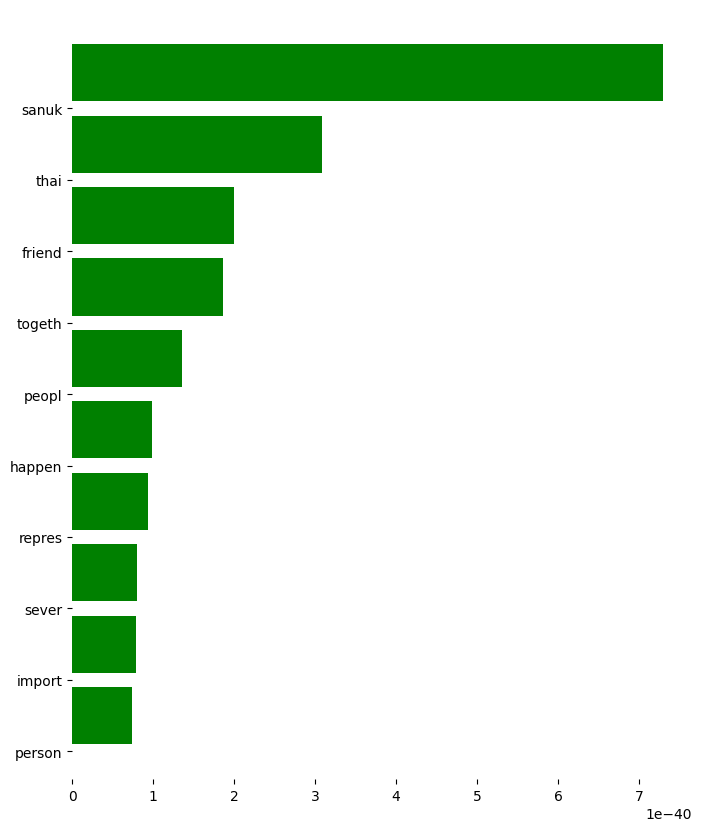

In [ ]:
lirme.visualize(explanation_vectors[0]["term_vector"], show_top = 10)

In [ ]:
word_list = list(lirme.get_document_vector(doc_id).keys())


[word_list[i] for i in ranked_lists[0]]

In [ ]:
#word_list.index('about')

term_vector = explanation_vectors[0]["term_vector"]

[word_list.index(x[0])  for x in term_vector]



In [ ]:
kendalltau(ranked_lists[0], ranked_lists[1])

#consistency and correctness

In [ ]:
lirme.consistency(ranked_lists, stype='kendall')

In [ ]:
lirme.correctness(doc_id, explanation_vectors[0]["term_vector"], relevant_doc_vector)

#ir_Datasets


In [ ]:
!pip install --upgrade ir_datasets
import ir_datasets

  Created wheel for cbor: filename=cbor-1.0.0-cp310-cp310-linux_x86_64.whl size=53431 sha256=b781e46729a41e79f4f59c82998b9a0fcc49cb8c947d48a3638e417ba7ccf495
  Stored in directory: /root/.cache/pip/wheels/85/df/c9/b39e40eccaf76dbd218556639a6dc81562226f4c6a64902c85
Successfully built warc3-wet-clueweb09 zlib-state cbor


In [ ]:
dataset = ir_datasets.load("disks45/nocr/trec-robust-2004")
query = 'counterfeiting money'
print(query)
query_id=0
for TrecQuery in dataset.queries_iter():
    if(TrecQuery.title  == query):
      print(TrecQuery)
      query_id = TrecQuery.query_id

query_id

In [ ]:
dataset = ir_datasets.load("msmarco-document/trec-dl-hard")
query = 'what is a lobster roll'
print(query)
query_id=0
for TrecQuery in dataset.queries_iter():
    #print(TrecQuery)
    #break

    #if(TrecQuery.text  == query):
    if("thai people" in TrecQuery.text):
      print(TrecQuery)
      TrecQuery
      query_id = TrecQuery.query_id

print(query_id)

what is a lobster roll
GenericQuery(query_id='1112341', text='what is the daily life of thai people')
1112341


In [ ]:
rel_docs_list = []
for qrel in dataset.qrels_iter():
    if(qrel.query_id  == query_id and qrel.relevance == 1):
     print(qrel)
     rel_docs_list.append(qrel.doc_id)

    if(len(rel_docs_list) >= 5  ):
      break

print("rel_docs_list: ", rel_docs_list)

relevant_doc_vector = lirme.compute_relevant_doc_vectors(rel_docs_list)

print("relevant_doc_vector : ", relevant_doc_vector)

In [ ]:
top_k_terms = 10
sorted(relevant_doc_vector.items(), key=lambda item: item[1], reverse=True)[:top_k_terms]

In [ ]:
relevant_doc_vector

In [ ]:
pw = Pointwise()

pw.explain(query, 1, reranker, retrieved_dict)

#Submission exs output

In [ ]:
#explainer = ExplainableSearch(reranker, 'svm', 100)

In [ ]:
rank = 1

explainer = ExplainableSearch(reranker, 'svm', 100)
#doc_ids = np.array([doc[0] for doc in bm25_example['hits']])
#print("doc_ids:",doc_ids)
docids_reranked = retrieved_dict["doc_ids"][np.argsort(retrieved_dict["rerank_scores"])[::-1]]  # descending order.
print("docids_reranked:",docids_reranked)
#print(type(docids_reranked))
doc_id_at_r = docids_reranked[rank-1]
print("doc_id at r:",doc_id_at_r)
doc_at_r = retrieved_dict["docs"][np.argsort(retrieved_dict["rerank_scores"])][-rank]
print("doc at r:",doc_at_r)

# build input for explaining function, use one query as example.
exp_input = {}
exp_input[query] = dict([(a, b) for a, b in zip(retrieved_dict["doc_ids"], retrieved_dict["rerank_scores"])])
#for key, value in exp_input[query].items():
#    print(key, value, '\n')
# explain the picked doc, use the 1-th ranked doc as the baseline, use topk-bin method.
# the returned results include {query: (words, weights)}.
exp_doc = {query: {'rank': rank-1,'text':doc_at_r}}

print("rank: ",rank)

#results = explainer.explain(exp_input, exp_doc , rank, 'topk-bin')
#explainer.visualize(results[query][0], results[query][1])

docids_reranked: ['8139255' '8139258' '8139256' '6164791' '90432' '2735215' '2096427'
 '6016292' '6740558' '2096429']
doc_id at r: 8139255
doc at r: {   "id" : "8139255",   "contents" : "An important thing in everyday life is SANUK. Thai people love to have fun together. SANUK can represent many things : eat together, to be with friends and chat, to go out with friends. For Thai people SANUK happens with several persons." }
rank:  1


In [ ]:
results = explainer.explain(exp_input, exp_doc , rank, 'topk-bin')
explainer.visualize(results[query][0], results[query][1], saveto = "entire_list", show_top=5)

##remove stopwords analyzer

In [ ]:
print(results[query][0])

from pyserini.analysis import Analyzer, get_lucene_analyzer
analyzer = Analyzer(get_lucene_analyzer())
tokens = analyzer.analyze(" ".join(results[query][0]))
print(tokens)
print(" ".join(tokens))

['8139255' 'an' 'and' 'be' 'can' 'chat' 'contents' 'eat' 'everyday' 'for'
 'friends' 'fun' 'go' 'happens' 'have' 'id' 'important' 'in' 'is' 'life'
 'love' 'many' 'out' 'people' 'persons' 'represent' 'sanuk' 'several'
 'thai' 'thing' 'things' 'to' 'together' 'with']
['8139255', 'can', 'chat', 'content', 'eat', 'everydai', 'friend', 'fun', 'go', 'happen', 'have', 'id', 'import', 'life', 'love', 'mani', 'out', 'peopl', 'person', 'repres', 'sanuk', 'sever', 'thai', 'thing', 'thing', 'togeth']
8139255 can chat content eat everydai friend fun go happen have id import life love mani out peopl person repres sanuk sever thai thing thing togeth


##remove stopwords using file

In [ ]:
with open("/content/stop.txt", 'r') as file:
    # Read the entire content of the file
    text = file.read()

    # Split the content into words
    stopwords = text.split()

print(stopwords)

['a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'conta

In [ ]:
results_no_stopword = {}
results_no_stopword[0] = []
results_no_stopword[1] = []

#print(results[query][1])
if len(results[query][1].shape) > 1:  # binary,
    results_score_array = np.squeeze(results[query][1])
#print(results_score_array)

for vocab,score in zip(results[query][0],results_score_array):
    #print(vocab,score)
    if(vocab not in stopwords):
      print(vocab,score)
      results_no_stopword[0].append(vocab)
      results_no_stopword[1].append(score)
      #pass

results_no_stopword[0] = np.array(results_no_stopword[0])
results_no_stopword[1] = np.array(results_no_stopword[1])
print(results_no_stopword)

8139255 1.21581604155343
chat -0.06634415358458508
contents 5.600946619891469
eat 2.9792822835356154
everyday -0.16369466220098294
friends -5.014364999725395
fun 9.952971847701884
id -1.2851484145475964
important -2.5423863302364236
life 12.800285506578517
love -6.148961968156905
people 4.1914084827037605
persons 0.6198279108612994
represent -9.266598878643178
sanuk -3.867740538555384
thai 11.539191119671681
thing 4.483328108715547
things 0.5447889587584651
{0: array(['8139255', 'chat', 'contents', 'eat', 'everyday', 'friends', 'fun',
       'id', 'important', 'life', 'love', 'people', 'persons',
       'represent', 'sanuk', 'thai', 'thing', 'things'], dtype='<U9'), 1: array([ 1.21581604, -0.06634415,  5.60094662,  2.97928228, -0.16369466,
       -5.014365  ,  9.95297185, -1.28514841, -2.54238633, 12.80028551,
       -6.14896197,  4.19140848,  0.61982791, -9.26659888, -3.86774054,
       11.53919112,  4.48332811,  0.54478896])}


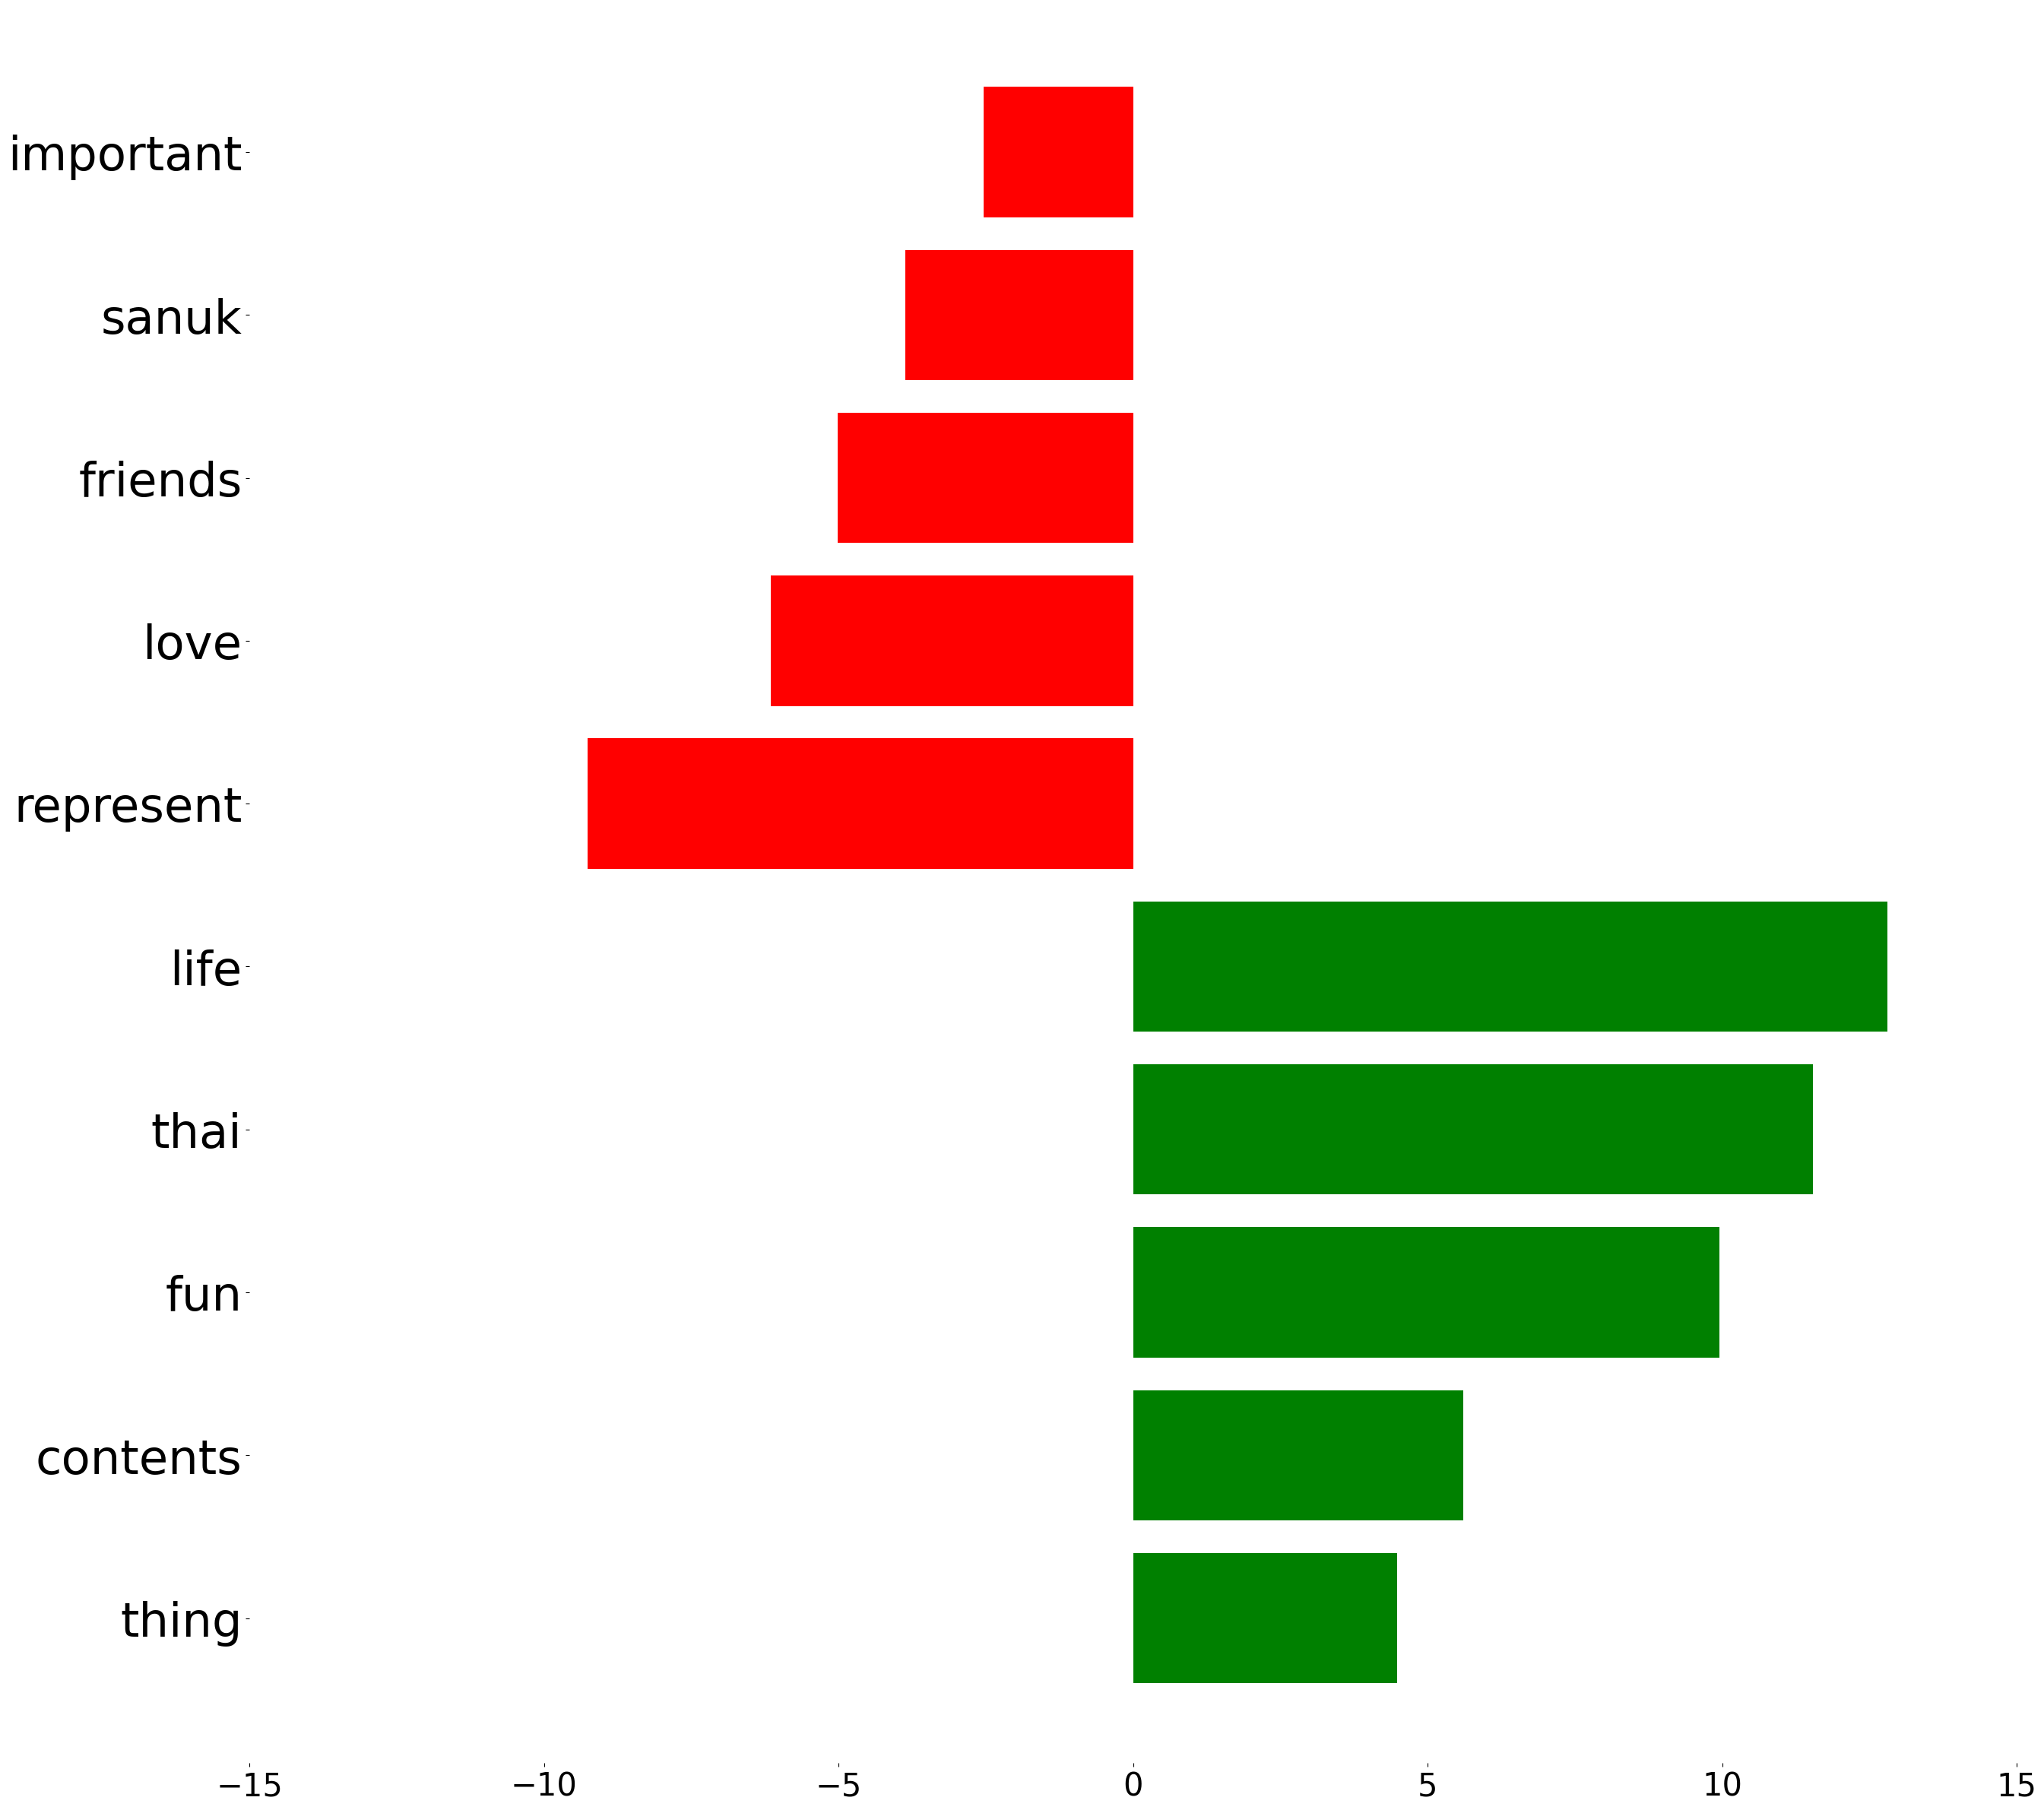

In [ ]:
explainer.visualize(results_no_stopword[0], results_no_stopword[1], saveto = "original_doc.pdf", show_top=5)

##auto random perturb

In [ ]:
#keep only one doc

retrieved_dict_mod = {}
retrieved_dict_mod["doc_ids"] = np.array(['FBIS4-46741'])

retrieved_dict_mod["rerank_scores"] =  np.array([9.5646584e-01])

retrieved_dict_mod
exp_input = {}
exp_input[query] = dict([(a, b) for a, b in zip(retrieved_dict_mod["doc_ids"], retrieved_dict_mod["rerank_scores"])])

#exp_doc remains same
#exp_doc = {query: {'rank': rank-1,'text':doc_at_r}}

In [ ]:
results = explainer.explain(exp_input, exp_doc , rank, 'topk-bin')
explainer.visualize(results[query][0], results[query][1], saveto = "only_one_doc")

In [ ]:
#PerturbDoc = PerturbDocument(self.num_samples)
sample_doc_generated = PerturbDocument(6).random_sampler(exp_doc[query]['text'])

print()
print(len(sample_doc_generated))
for d in sample_doc_generated:
  print(d)

print(sample_doc_generated[1])

perturb_rerank_scores = PerturbDocument().score_samples_with_reranker(query, sample_doc_generated, reranker)
print("perturb_rerank_scores: ", perturb_rerank_scores)

##manual perturb

In [ ]:
sample_doc_perturbed = []
sample_doc_perturbed.append("An important thing in everyday life is SANUK. Thai people love to have fun together. SANUK represents many things : eat together, to be with friends and chat, to go out with friends. For most Thai people SANUK happens with multiple persons." )


print(query)
print(sample_doc_perturbed)

perturb_rerank_scores = PerturbDocument().score_samples_with_reranker(query, sample_doc_perturbed, reranker)
print("perturb_rerank_scores: ", perturb_rerank_scores)

what is the daily life of thai people
['An important thing in everyday life is SANUK. Thai people love to have fun together. SANUK represents many things : eat together, to be with friends and chat, to go out with friends. For most Thai people SANUK happens with multiple persons.']


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

perturb_rerank_scores:  [0.99130136]


In [ ]:
#perturb that one doc
pert_idx = 0

retrieved_dict_pert = {}
retrieved_dict_pert["doc_ids"] = np.array([doc_id_at_r + "_perturbed"])

retrieved_dict_pert["rerank_scores"] =  np.array([perturb_rerank_scores[pert_idx]])

retrieved_dict_pert
exp_input = {}
exp_input[query] = dict([(a, b) for a, b in zip(retrieved_dict_pert["doc_ids"], retrieved_dict_pert["rerank_scores"])])

#exp_doc changes
exp_doc_pert = {query: {'rank': rank-1,'text':sample_doc_perturbed[pert_idx]}}

In [ ]:
print(retrieved_dict_pert)

print(exp_input[query])

exp_doc_pert

{'doc_ids': array(['8139255_perturbed'], dtype='<U17'), 'rerank_scores': array([0.99130136], dtype=float32)}
{'8139255_perturbed': 0.99130136}


{'what is the daily life of thai people': {'rank': 0,
  'text': 'An important thing in everyday life is SANUK. Thai people love to have fun together. SANUK represents many things : eat together, to be with friends and chat, to go out with friends. For most Thai people SANUK happens with multiple persons.'}}

In [ ]:
results_pert = explainer.explain(exp_input, exp_doc_pert , rank, 'topk-bin')
#explainer.visualize(results_pert[query][0], results_pert[query][1], saveto = "only_one_doc_perturbed", show_top=5)

Inside def explain, scores_topk:
 [0.99130136]


99it [00:00, 3540.43it/s]


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

lables_perturb unique:  [0 1]
Inside def explain_single, self.exs_model:  svm


In [ ]:
results_pert_no_stopword = {}
results_pert_no_stopword[0] = []
results_pert_no_stopword[1] = []

#print(results[query][1])
if len(results_pert[query][1].shape) > 1:  # binary,
    results_pert_score_array = np.squeeze(results_pert[query][1])
#print(results_score_array)

for vocab,score in zip(results_pert[query][0],results_pert_score_array):
    #print(vocab,score)
    if(vocab not in stopwords):
      print(vocab,score)
      results_pert_no_stopword[0].append(vocab)
      results_pert_no_stopword[1].append(score)
      #pass

results_pert_no_stopword[0] = np.array(results_pert_no_stopword[0])
results_pert_no_stopword[1] = np.array(results_pert_no_stopword[1])
print(results_pert_no_stopword)

chat -2.106493017994481
eat -10.447034325223939
everyday 8.376353832988363
friends -1.1216091435897586
fun -4.25286206091116
important 7.176451793501879
life 13.088511130212536
love 0.16074833714281692
multiple 2.0276142178812377
people 2.6069097769791383
persons 7.349464797121495
represents -15.599812969379647
sanuk -8.755657830612657
thai -6.56266691030756
thing 0.8992412950029383
things -4.427323623233022
{0: array(['chat', 'eat', 'everyday', 'friends', 'fun', 'important', 'life',
       'love', 'multiple', 'people', 'persons', 'represents', 'sanuk',
       'thai', 'thing', 'things'], dtype='<U10'), 1: array([ -2.10649302, -10.44703433,   8.37635383,  -1.12160914,
        -4.25286206,   7.17645179,  13.08851113,   0.16074834,
         2.02761422,   2.60690978,   7.3494648 , -15.59981297,
        -8.75565783,  -6.56266691,   0.8992413 ,  -4.42732362])}


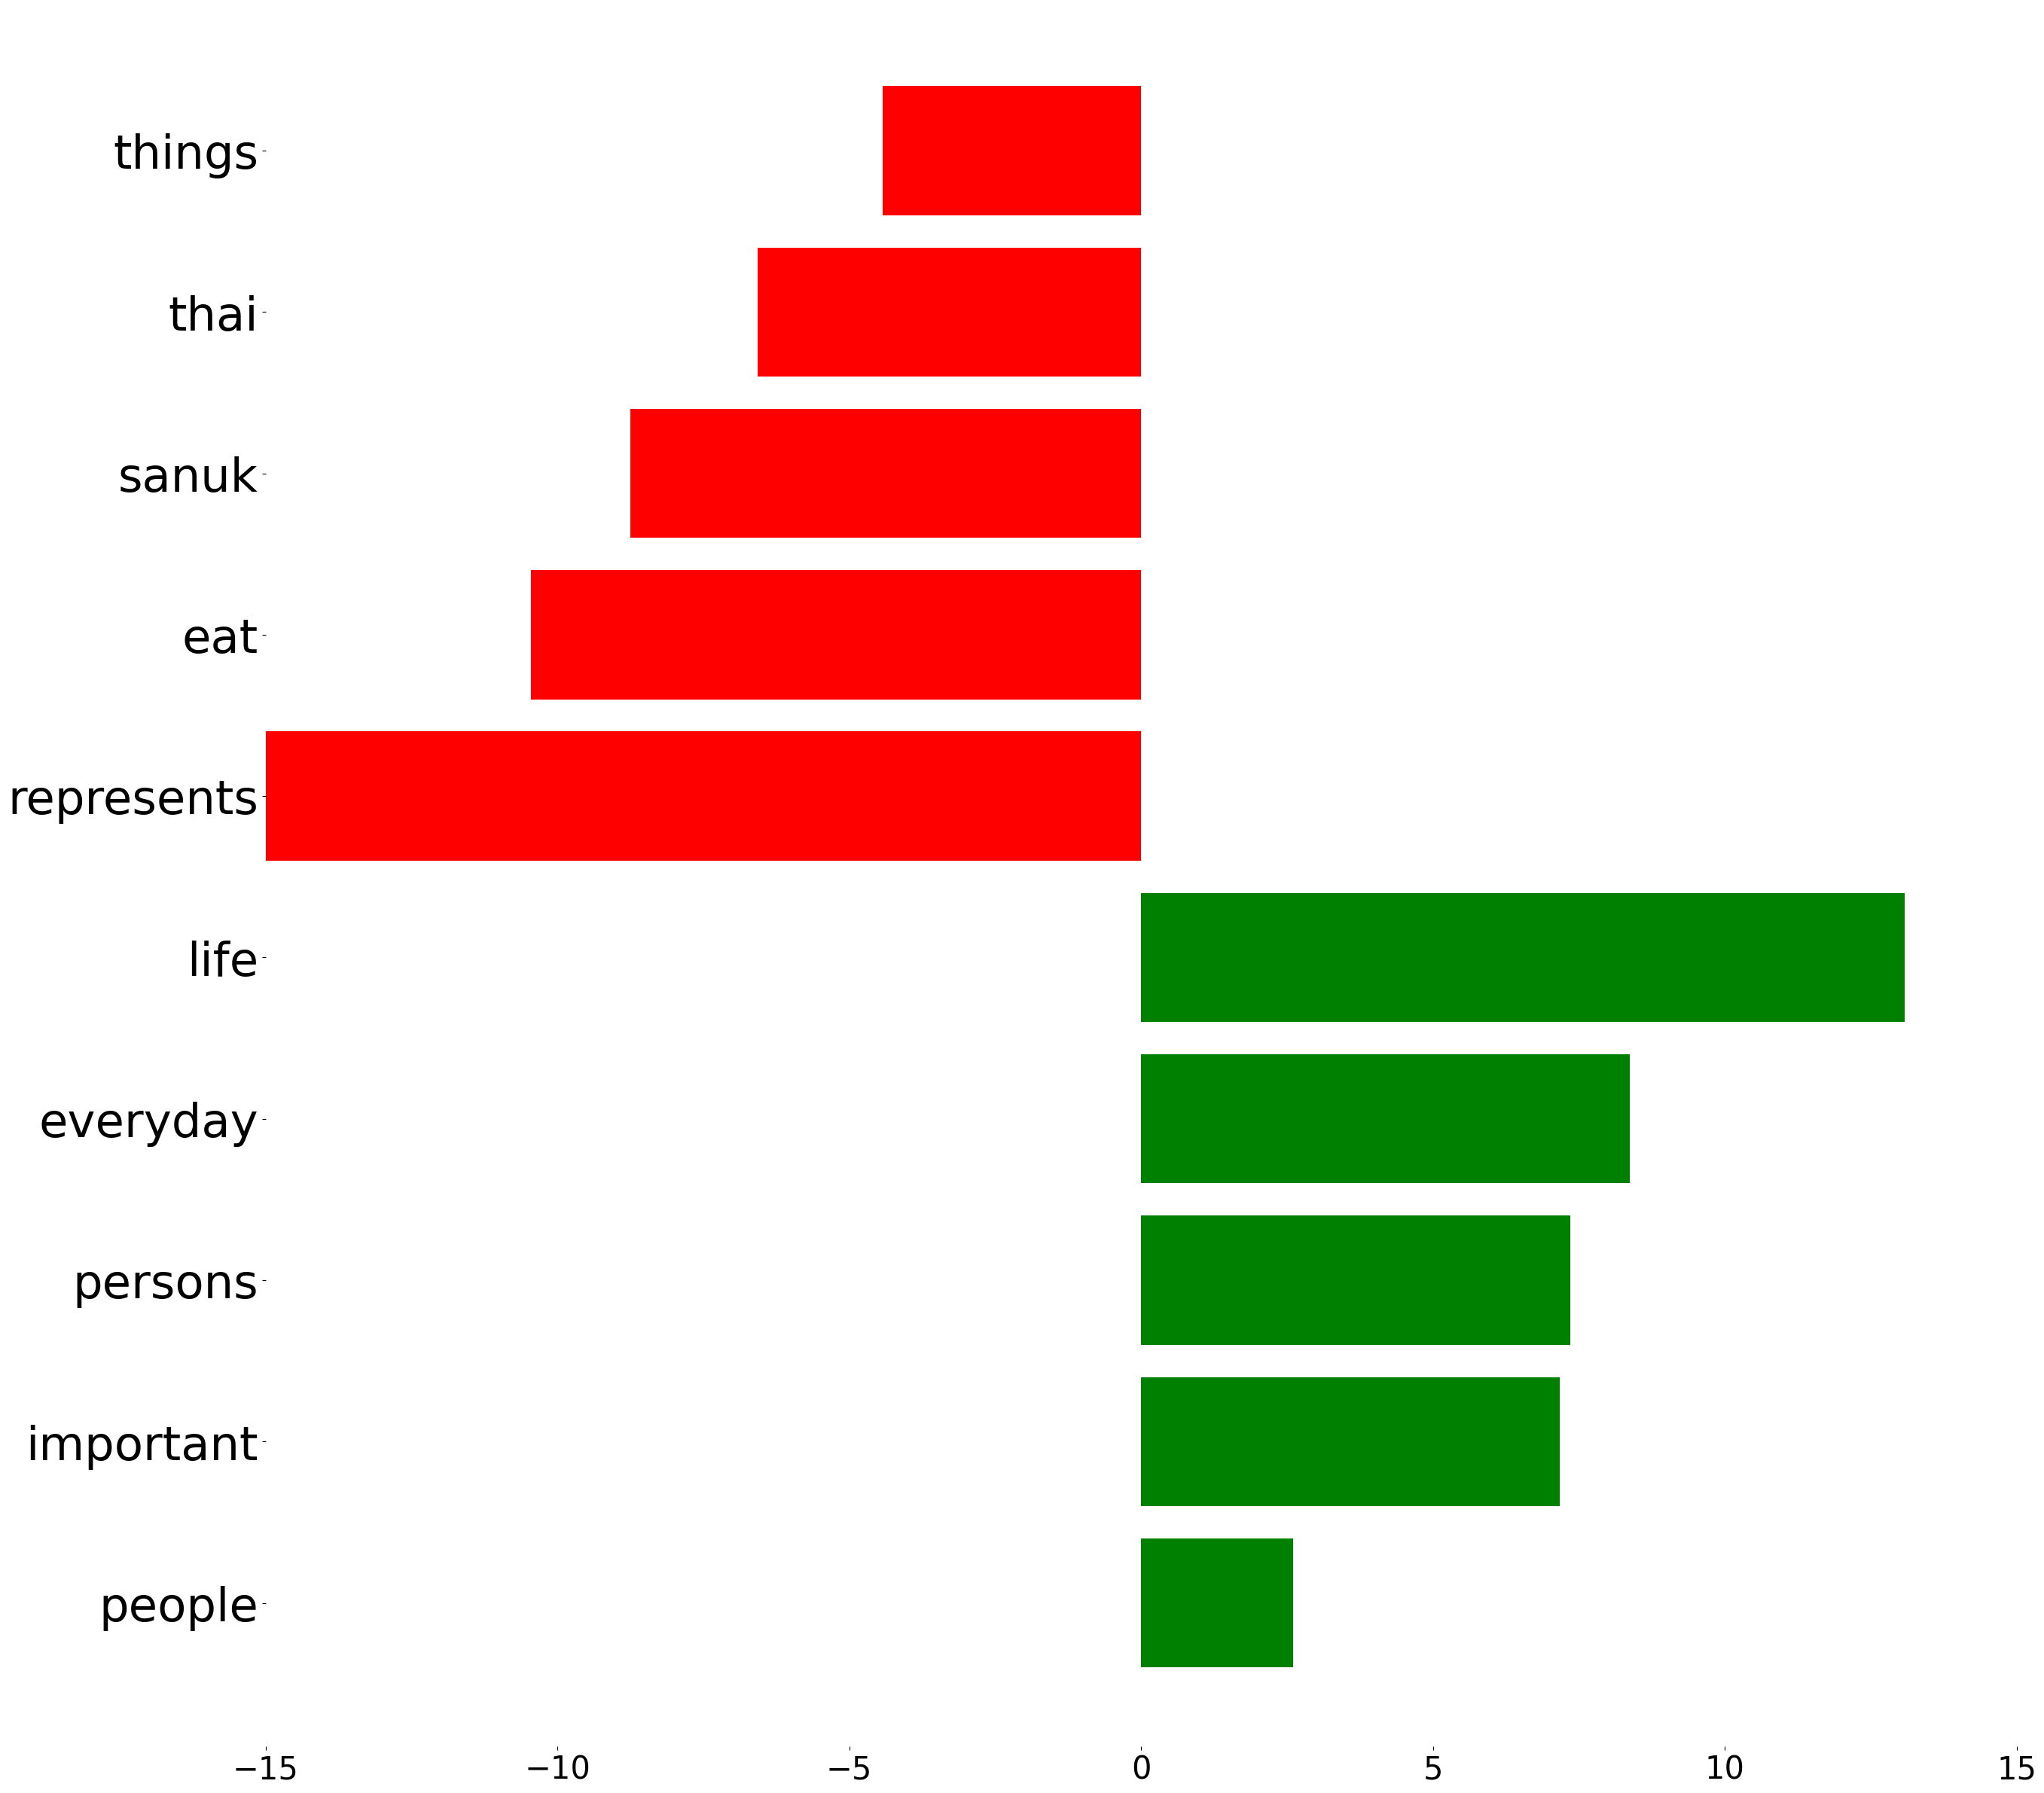

In [ ]:
explainer.visualize(results_pert_no_stopword[0], results_pert_no_stopword[1], saveto = "perturbed_doc.pdf", show_top=5)